# <center> Lecture10 : Multiple regression </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## 回顾  

在前面的九次课程中，我们系统性地介绍了贝叶斯统计的核心概念，并通过一个简单的线性回归模型展示了如何构建和应用一个相对简单的贝叶斯workflow。

![Image Name](https://cdn.kesci.com/upload/smkhdwv5zt.png?imageView2/0/w/720)



核心的知识点包括：

（1）贝叶斯公式——基础：

![Image Name](https://cdn.kesci.com/upload/skvbchkz1s.jpg?imageView2/0/w/960/h/960)  




为了帮助大家建立关于贝叶斯推断的直觉，我们使用了三种情境：单一事件、离散变量和连续变量。 

| 知识点         | 内容描述                                         | 先验                   |   似然                          | 贝叶斯更新                     |  
|---------------|------------------------------------------------|------------------------|--------------------------------|------------------------------|  
| **单个事件**    | 一个使用特定语言风格的心理学实验被成功重复出来的可能性  | [OSC2015](https://doi.org/10.1126/science.aac4716)的结果           |   [Herzenstein et al 2024](https://doi.org/10.1177/09567976241254037 )年的研究结果     | 可视化的方式 + 简单计算         |  
| **离散变量**       | 多次试验(多次进行重复实验)的成功率                  | 人为分配的三种成功率(0.2, 0.5, 0.8)和它们出现的可能性  | 进行重复后的结果在**三种**成功率下出现的可能性 | 简单的手动计算 |  
| **连续变量**       | 多次试验(多次进行重复实验)的成功率/正确率                  | 符合成功率/正确率(0~1)特点和先验经验的概率分布| 进行重复后的结果在**所有**成功率/正确率下出现的可能性 | 已被证明的统计学公式|



在第八、九两课中，我们以一个认知实验中的研究问题——**自我和他人条件下的反应时间是否有差异**  出发，建立了一个简单的线性回归模型，并完成了贝叶斯数据分析的全流程。

<p align="center">
  <img src="https://cdn.kesci.com/upload/smipfxtgj4.png?imageView2/0/w/640/h/640" alt="Image Name">
</p>


<p align="center">
  <img src="https://cdn.kesci.com/upload/smkijcu8co.png?imageView2/0/w/460" alt="Image Name">
</p>

> Sui, J., He, X., & Humphreys, G. W. (2012). Perceptual effects of social salience: Evidence from self-prioritization effects on perceptual matching. Journal of Experimental Psychology: Human Perception and Performance, 38(5), 1105–1117. https://doi.org/10.1037/a0029792  

<div style="padding-bottom: 30px;"></div>



至此，我们可以开始进入更真实的场景，使用贝叶斯数据分析来解决一个真实的问题。

第八、九两课中使用的简化数据，背后的完整数据是什么？

**真实数据如下：**

In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [ ]:
try:
  df_raw = pd.read_csv('/home/mw/input/bayes3797/Kolvoort_2020_HBM_Exp1_Clean.csv')
except:
  df_raw = pd.read_csv('/data/Kolvoort_2020_HBM_Exp1_Clean.csv')

df = df_raw.groupby(['Subject','Label', 'Matching'], as_index=False)['RT_sec'].mean()

# 将 Label 列的数字编码转为文字标签
df['Label'] = df['Label'].replace({1: 'Self', 2: 'Friend', 3: 'Stranger'})

df['Matching'] = df['Matching'].replace({'Matching': 'matching', 'Nonmatching': 'nonmatching'})

# 设置索引
df["index"] = range(len(df))
df = df.set_index("index")

df

,Subject,Label,Matching,RT_sec
index,,,,
0,201,Self,matching,0.710595
1,201,Self,nonmatching,0.739987
2,201,Friend,matching,0.789074
3,201,Friend,nonmatching,0.852600
4,201,Stranger,matching,0.913667
...,...,...,...,...
181,234,Self,nonmatching,0.874204
182,234,Friend,matching,0.963889
183,234,Friend,nonmatching,1.094103


In [4]:
print(f"Label列共有 {df['Label'].unique()} 类" )

Label列共有 ['Self' 'Friend' 'Stranger'] 类


通过查看数据可知，在自我匹配任务中，被试学习几何图形和身份标签的关系应为，例如，三角形代表自我（Self）；圆形代表朋友（Friend），正方形代表陌生人（Stranger），随后判断所呈现的几何图形和文字标签是否与之前学习的关系相匹配。   

![Image Name](https://cdn.kesci.com/upload/snajcrx0jy.png?imageView2/0/w/640/h/960)

> Sui, J., He, X., & Humphreys, G. W. (2012). Perceptual effects of social salience: Evidence from self-prioritization effects on perceptual matching. Journal of Experimental Psychology: Human Perception and Performance, 38(5), 1105–1117. https://doi.org/10.1037/a0029792  



因此，真实的实验情境是一个2*3的被试内实验设计的数据。其中，标签（自我相关性）是可以有三个水平的：自我、朋友和陌生人。


如果我们对标签的效应感兴趣，那我们可能就要回答这个问题：**“三种Label条件下的反应时差异是怎么样的？”，即如何构建“Label”变量编码为3个水平的线性模型？**




同时，该实验设计还有另一个自变量，即匹配水平(“Matching”)，包括“匹配”和“不匹配”两个水平。这个自变量会对反应时间产生影响吗？

这是第二个研究问题：**“匹配水平(“matching”)是否会影响反应时间？**”。

通常，我们也可能想知道第三个问题：两个自变量之间是否有交互作用？在不同的匹配水平(“matching”)下，标签“Label”的效应是否会发生变化？。

Q：传统的心理统计学中，我们使用什么统计检验来回答上述的问题？


本节课我们将展示如何在贝叶斯统计框架下，通过3个线性回归模型来回答以上问题：

- 三水平的简单线性回归模型
- 2 X 3的多元线性回归模型（无交互）
- 2 X 3的多元线性回归模型（有交互）

注：为了简化研究问题，本节课使用的是多个被试的数据。“Subject” 为被试编号，代表不同被试。

此外，数据中的因变量不是单个试次下被试的反应时和正确性，而是在不同条件下的平均反应时和正确率。

## 模型一：三水平的简单线性回归模型

在前面两次课时中，我们使用了二分类编码（例如Self = 0, Other = 1）来表示“Label”条件，但这次我们考虑的是三水平的单因素“label”条件（Self、Friend、Stranger）。

为了能对离散的多分类变量建立回归模型，我们需要使用**哑变量编码(dummy coding)**来处理这类多水平的自变量。


### 哑变量编码规则

对于三水平分类变量 “Label” (Self, Friend, Stranger)，我们可以使用 Treatment Coding 编码，以第一个水平 "Self" 作为基准（baseline）。

那么，什么是treatment编码？🤔

在回归分析中，自变量可以是数值型的（如身高、体重）或分类型的（如性别、实验组别）。对于分类变量（如 Label：Self、Friend、Stranger），因为它们是文本或类别，无法直接输入到回归模型中，因此需要将它们转换为数值形式。

treatment编码是将分类变量转化为数值型变量的一种常见方式，通常是：
1. 选择一个基线水平（Baseline level）：通常是分类变量的第一个水平；
2. 创建哑变量：通过 n-1 个对比列，表示其他水平相对于基准水平的差异。

那么，当我们选择“self”作为基线水平，编码矩阵应该如下：

| Label     | 截距(baseline) | 对比列 1 (Friend vs Self)      | 对比列 2 (Stranger vs Self)      |
| --------- | ------------ | --------------------------- | ----------------------------- |
| Self      | 1            | 0                           | 0                             |
| Friend    | 1            | 1                           | 0                             |
| Stranger  | 1            | 0                           | 1                             |

- 截距(baseline)，对应 Self，即当所有对比列值为 0 时，截距 $\beta_0$ 对应 Self 条件下平均反应时的估算。
- Friend：在第一列中为 1，表示其相对于 Self 的差异。
- Stranger：在第二列中为 1，表示其相对于 Self 的差异。

<div style="padding-bottom: 30px;"></div>

**其他编码模式**

treatment coding这种以 [0, 1] 的编码方式是R语言中的默认方式，也称为哑变量编码（dummy coding）。这种方式以 [0, 1] 为编码规则，默认将第一个因子水平作为参考类别（reference level），其他水平与其进行比较。

此外无序因子常用的还有sum coding，采用的是[1, -1]的编码方式，以使因子效应在模型中进行加权平均。


其他的编码方式还有很多，如果感兴趣，可以通过以下参考资料自行了解。

| 编码方式                | 编码规则                                                              |
|-------------------------|-----------------------------------------------------------------------|
| **Treatment Coding**    | 参考水平编码为 0，其余水平编码为 1                                   |
| **Sum Coding**          | 一个水平编码为 -1，其余水平编码为 1，所有系数和为 0                  |
| **Helmert Coding**      | 每个水平与之后所有水平的平均值比较                                   |
| **Orthogonal Polynomial Coding** | 使用正交多项式编码函数（线性、二次、三次趋势）               |
| **Backward Difference Coding**   | 每个水平与前一个水平比较                                      |
| **Custom Coding**       | 用户自定义编码规则                                                  |




> 参考资料：
> 1. [Chapter 10 Contrasts | Analysing Data using Linear Models](https://bookdown.org/pingapang9/linear_models_bookdown/contrasts.html)
> 2. [Patsy: Contrast Coding Systems for categorical variables - statsmodels 0.15.0 (+522)](https://www.statsmodels.org/devel/contrasts.html)
> 3. [Coding for Categorical Variables in Regression Models | R Learning Modules](https://stats.oarc.ucla.edu/r/modules/coding-for-categorical-variables-in-regression-models/#:~:text=%E2%80%9CDummy%E2%80%9D%20or%20%E2%80%9Ctreatment%E2%80%9D%20coding%20basically%20consists%20of%20creating,variable%20is%20contrasted%20to%20a%20specified%20reference%20level.)
> 4. Schad, D. J., Vasishth, S., Hohenstein, S., & Kliegl, R. (2020). How to capitalize on a priori contrasts in linear (mixed) models: A tutorial.Journal of Memory and Language,110, 104038.

<div style="padding-bottom: 30px;"></div>

#### 为什么需要哑变量编码？

在三水平简单线性回归模型中，因变量（Y：RT_sec）和分类自变量X（Label：Self, Friend, Stranger）的关系可以表示为：

$$
Y = \beta_0 + \beta_1 \cdot X_1 + \beta_2 \cdot X_2 + \epsilon_i
$$

其中：

- $\beta_0$：基准水平 Self 的均值。
- $\beta_1$：Friend 相对于 Self 的均值差异。
- $\beta_2$：Stranger 相对于 Self 的均值差异。
- $X_1, X_2$：对比列变量（Friend vs Self 和 Stranger vs Self）。

通过 Treatment 编码：

- $\beta_0$：直接表示基准组（Self）的均值。
- $\beta_1$ 和 $\beta_2$：表示其他水平相对于基准组的差异。
  
🤓可以发现，$\beta_1$ 和 $\beta_2$ 分别对应我们关心的两种研究问题：自我条件下的反应时是否快于朋友条件? 以及自我条件下的反应时是否快于陌生人条件？

我们可以通过上节课学习的后验推断方法来对两种假设进行检验。

### 模型拟合和推断

在了解哑变量之后，我们就可以开始进行模型拟合和推断了。

为了演示简便，我们使用一个简化的 workflow 流程。

<p align="center">
  <img src="https://cdn.kesci.com/upload/sm7veon5ei.png?imageView2/0/w/720/h/960" alt="Image Name">
</p>

**选择模型和数据处理**

根据哑变量编码明确了所选择的模型为： $Y = \beta_0 + \beta_1 \cdot X_1 + \beta_2 \cdot X_2 + \epsilon_i$。 

由于模型需要 $X_1$ 和 $X_2$ 两个变量，因此需要首先对数据进行这两个变量的编码处理。

In [5]:
# 将 Label 列转换为有序的分类变量
df['Label'] = pd.Categorical(df['Label'], categories=['Self', 'Friend', 'Stranger'], ordered=True)

df['Label']

index
0          Self
1          Self
2        Friend
3        Friend
4      Stranger
         ...   
181        Self
182      Friend
183      Friend
184    Stranger
185    Stranger
Name: Label, Length: 186, dtype: category
Categories (3, object): ['Self' < 'Friend' < 'Stranger']

In [6]:
# 将分类变量转换为哑变量
X1 = (df['Label'] == 'Friend').astype(int)
X2 = (df['Label'] == 'Stranger').astype(int)

**先验设定**：

本模型使用三个水平的哑变量编码，相比上节课的简单线性模型，产生一个额外参数 $\beta_2$。

因此，我们需要为截距（$\beta_0$）、斜率（$\beta_1, \beta_2$）、以及误差项（$\sigma$）设置先验分布。

1. 截距 $\beta_0$ ：基准水平 Self 的均值，即在 Self 条件下反应时间的平均值。

$$ \beta_0 \sim N(5, 2^2) $$

即，假设 Self 条件下的平均反应时间为 5 秒，标准差为 2，表示在 3 至 7 秒范围内有较高的概率。


2. $\beta_1$：Friend 相对于 Self 的均值差异；  $\beta_2$：Stranger 相对于 Self 的均值差异。

$$ \beta_1 \sim N(0, 1^2), \quad \beta_2 \sim N(0, 1^2) $$


- $\beta_1$：假设 Friend 相对于 Self 的均值差异小且对称分布，可能是正值或负值。
- $\beta_2$：假设 Stranger 相对于 Self 的均值差异小，且对称分布，可能是正值或负值。
  
3. 误差项 $\sigma$：数据围绕预测均值 $\mu_i$ 的波动。使用指数分布 $Exp(0.3)$，与两水平时一致： $$ \sigma \sim Exp(0.3) $$

即，假设反应时间的波动集中在小范围，允许中等程度的波动（通常在 0 到 10 秒范围）。


**完整模型设定**


模型可表示为：
$$ Y_i \mid \beta_0, \beta_1, \beta_2, \sigma \sim N(\mu_i, \sigma^2), \quad \mu_i = \beta_0 + \beta_1 \cdot X_1 + \beta_2 \cdot X_2 $$

先验分布：

- $\beta_0$： $$ \beta_0 \sim N(5, 2^2) $$
- $\beta_1$ 和 $\beta_2$ ： $$ \beta_1 \sim N(0, 1^2), \quad \beta_2 \sim N(0, 1^2) $$
- $\sigma$： $$ \sigma \sim Exp(0.3) $$



先验设置：

* > $Y_i {\sim} N\left(\mu_i, \sigma^2\right)$  

* > $\sigma   \sim \text{Exp}(0.3)$  
  
* > $\beta_{0}   \sim N\left(5, 2^2 \right)$  

* > $\beta_1   \sim N\left(0, 1^2 \right)$  

* > $\beta_2   \sim N\left(0, 1^2 \right)$  
  
定义回归模型：
* > $\mu_i = \beta_0 + \beta_1 X_1 + \beta_2 X_2$

我们可以通过 PyMC 构建该模型，并使用 MCMC 算法进行采样。

In [7]:
import pymc as pm

# 建立模型
with pm.Model() as model1:
    # 定义先验分布参数
    beta_0 = pm.Normal('beta_0', mu=5, sigma=2)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=0.3)
    
    # 线性模型表达式
    mu = beta_0 + beta_1 * X1 + beta_2 * X2
    
    # 观测数据的似然函数
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=df['RT_sec'])


**进行后验采样**

接下来我们使用`pm.sample()`进行mcmc采样  

In [8]:
with model1:
    model1_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples=True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)           # 后验采样  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


**MCMC诊断和后验推断**

我们可以使用 `az.summary` 函数来查看诊断和后验推断的摘要。

In [9]:
az.summary(model1_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.703,0.017,0.671,0.735,0.0,0.0,10448.0,11581.0,1.0
beta_1,0.064,0.024,0.018,0.108,0.0,0.0,11335.0,11617.0,1.0
beta_2,0.061,0.024,0.014,0.105,0.0,0.0,12312.0,12968.0,1.0
sigma,0.133,0.007,0.120,0.147,0.0,0.0,13834.0,13622.0,1.0


使用 ROPE+HDI 对参数进行检验

- 可以看到，$\beta_1$ 和 $\beta_2$ 参数的置信区间没有包含 0，但两者均与 ROPE 重叠，表明效应不明显。 可以使用贝叶斯因子进行进一步假设检验。
- 此外，$\beta_1$ 的效应在均值和 HDI 范围均大于 $\beta_2$。

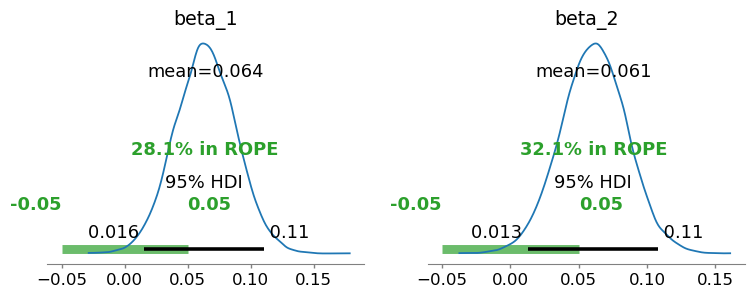

In [10]:
# 定义 ROPE 区间，根据研究的需要指定实际等效范围
rope_interval = [-0.05, 0.05]

# 绘制后验分布，显示 HDI 和 ROPE
az.plot_posterior(
    model1_trace,
    var_names=["beta_1", "beta_2"],
    hdi_prob=0.95,
    rope=rope_interval,
    figsize=(9, 3),
    textsize=12
)

plt.show()

使用贝叶斯因子进行差异检验

- 无论对于 $\beta_1$ 还是 $\beta_2$，$BF_{10}$ 都接近与1，表明两个参数都没有证据支持它们和0有区别。

Sampling: [Y_obs, beta_0, beta_1, beta_2, sigma]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


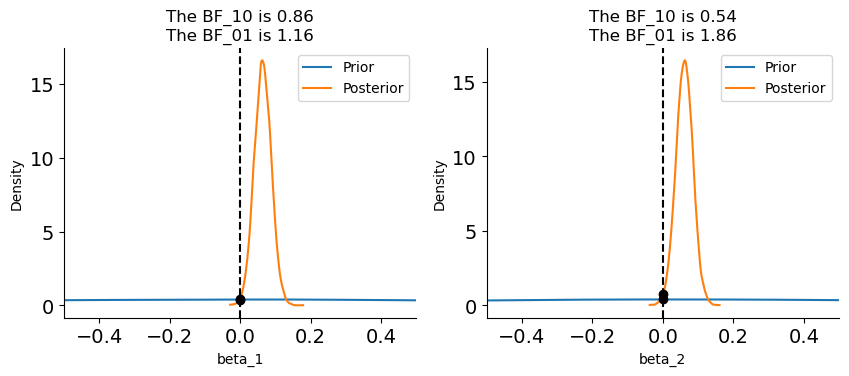

In [11]:
# 进行贝叶斯因子计算，需要采样先验分布
with model1:
    model1_trace.extend(pm.sample_prior_predictive(5000, random_seed=84735) )

fig, axes = plt.subplots(1,2, figsize=(10, 3.5))

# 绘制贝叶斯因子图
ax = axes[0]
az.plot_bf(model1_trace, var_name="beta_1", ref_val=0, ax=ax)
# 设置 x 轴的范围
ax.set_xlim(-0.5, 0.5) 
ax = axes[1]
az.plot_bf(model1_trace, var_name="beta_2", ref_val=0, ax=ax)
# 设置 x 轴的范围
ax.set_xlim(-0.5, 0.5) 

# 去除上框线和右框线
sns.despine()
plt.show()

**后验预测**

最后，我们可以使用 `pm.sample_posterior_predictive` 函数来生成后验预测。

并通过 `az.plot_ppc` 函数来绘制后验预测的基本结果。

In [12]:
with model1:
    model1_ppc = pm.sample_posterior_predictive(model1_trace, random_seed=84735) 


Sampling: [Y_obs]


Output()

<Axes: xlabel='Y_obs'>

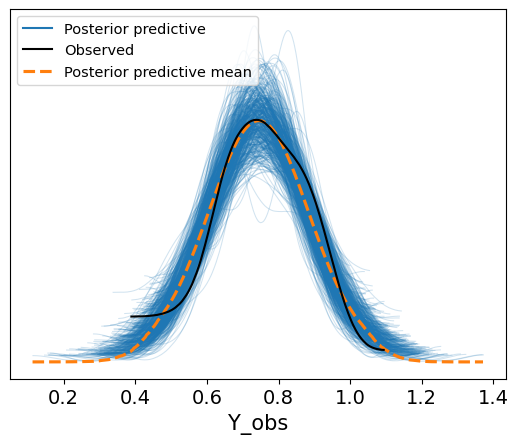

In [13]:
az.plot_ppc(model1_ppc, num_pp_samples = 500)

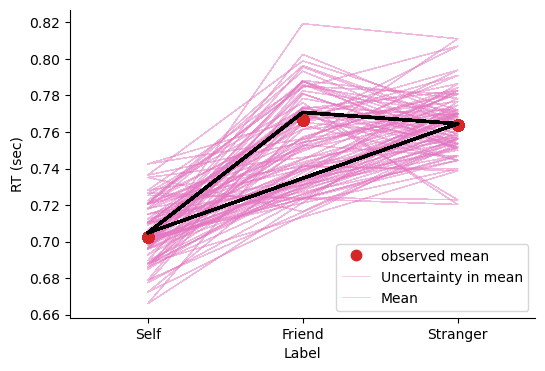

In [14]:
import xarray as xr

# 导入真实的自变量
X1 = xr.DataArray((df['Label'] == 'Friend').astype(int))
X2 = xr.DataArray((df['Label'] == 'Stranger').astype(int))

# 基于后验参数生成y_model
model1_trace.posterior["y_model"] = model1_trace.posterior["beta_0"] + model1_trace.posterior["beta_1"] * X1 + model1_trace.posterior["beta_2"] * X2
df['Mean RT'] = df.groupby('Label')['RT_sec'].transform('mean')

# 绘制后验预测线性模型
az.plot_lm(
           y= df['Mean RT'],
           x= df.Label,
           y_model = model1_trace.posterior["y_model"],
           y_model_mean_kwargs={"color":"black", "linewidth":2},
           figsize=(6,4),
           textsize=16,
           grid=False)

# 设置坐标轴标题、字体大小
plt.xlim(-0.5, 2.5) 
plt.xticks([0, 1, 2]) 
plt.xlabel('Label')  
plt.ylabel('RT (sec)')  
plt.legend(['observed mean', 'Uncertainty in mean', 'Mean']) 

sns.despine()

ArviZ 自带的绘图工具不够灵活和美观。 我们可以自己定义函数来绘制后验预测线性模型。

In [15]:
def plot_prediction(df, predicted_y="prediction", ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))
    
    sns.boxplot(x='Label', y='RT_sec', hue='Matching', data=df, palette='Set2', ax=ax)

    prediction = df.groupby(["Label", "Matching"])[predicted_y].mean().reset_index()
    # 创建映射字典：Label到x位置
    label_to_x = {'Self': 0, 'Friend': 1, 'Stranger': 2}
    # 将 Label 映射到相应的 x 值
    prediction['x_position'] = prediction['Label'].map(label_to_x)
    # 根据 Matching 设置偏移量
    prediction['x_offset'] = np.where(prediction['Matching'] == 'matching', -0.2, 0.2)
    # 计算最终的 x 位置
    prediction['final_x'] = prediction['x_position'].to_numpy() + prediction['x_offset'].to_numpy()

    ax.plot(prediction['final_x'], prediction[predicted_y], marker='o', linestyle='', color='red', label="prediction")
    ax.legend()


In [16]:
import xarray as xr

# 导入真实的自变量
X1 = xr.DataArray((df['Label'] == 'Friend').astype(int))
X2 = xr.DataArray((df['Label'] == 'Stranger').astype(int))

model1_trace.posterior["y_model"] = model1_trace.posterior["beta_0"] + model1_trace.posterior["beta_1"] * X1 + model1_trace.posterior["beta_2"] * X2

df["model1_prediction"] = model1_trace.posterior.y_model.mean(dim=["chain","draw"]).values

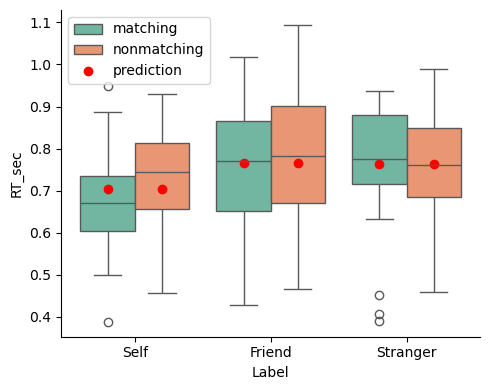

In [17]:
plot_prediction(df, "model1_prediction")

# 显示图形
sns.despine()
plt.tight_layout()
plt.show()

可以看到，当仅考虑“Label”条件时，由于没有考虑到“Matching”条件的影响，模型预测的 y 值与真实值存在较大的偏差。


## 模型二：2 X 3 的多元线性回归模型：无交互

模型一仅考虑了“Label”对模型的影响。

然而，反应时间可能不仅受到标签的影响，还可能受到匹配水平(matching)的影响。因此，第二个研究问题是：“**匹配条件是否会影响反应时间？**”。

如果把“matching”条件加入到模型中，会不会让模型更好？我们来看看如何建立模型二。


### 哑变量编码规则

模型二加入了新的自变量“Matching”（matching， non-matching），我们先不考虑两个自变量之间的交互作用，即“Label”和“Matching”是独立的影响因素。在新的模型中，“Label”是一个三水平因子（Self、Friend、Stranger），而“Matching”是一个二水平因子（matching、non-matching）。

因此，我们需要对两者分别进行treatment编码，然后将其合并为模型矩阵。

**模型设计与编码规则**

- Label (三水平因子): 采用 treatment 编码，将 "Self" 作为基线，生成两个对比列：
    - Contrast 1：Friend vs Self
    - Contrast 2：Stranger vs Self

- Matching (二水平因子): 采用 treatment 编码，将 "matching" 作为基线，生成一个对比列：
    - Contrast3 (matching vs non-matching)



最终，模型矩阵将有：

- 一个截距列（表示基线条件 “Self-matching” 的反应时间）。
- 两个与 “Label” 相关的对比列。
- 一个与 “matching” 相关的对比列。

三个 $\beta$ 参数对应了三种对比假设。即，假设 Friend 与 Self 的反应时间相同，Stranger 与 Self 的反应时间相同，nonmatching 与 matching 的反应时间相同。

| Label    | Matching  | 截距 (baseline) | Contrast1 (Friend vs Self) | Contrast2 (Stranger vs Self) | Contrast3 (matching vs nonmatching) |
|----------|-----------|-----------------|----------------------------|------------------------------|--------------------------------|
| Self     | matching    | 1               | 0                          | 0                            | 0                              |
| Friend   | matching      | 1               | 1                          | 0                            | 0                              |
| Stranger | matching      | 1               | 0                          | 1                            | 0                              |
| Self     | nonmatching  | 1               | 0                          | 0                            | 1                              |
| Friend   | nonmatching  | 1               | 1                          | 0                            | 1                              |
| Stranger | nonmatching  | 1               | 0                          | 1                            | 1                              |


<div style="padding-bottom: 30px;"></div>

在模型二中，两个分类自变量$X$（Label：Self, Friend, Stranger） 和 $M$ （Matching：matching, nonmatching ）的关系可以表示为：

$$
Y = \beta_0 + \beta_1 \cdot X_1 + \beta_2 \cdot X_2 + \beta_3 \cdot M_1 + \epsilon_i
$$

通过Treatment 编码：
- $\beta_0$：表示基准条件（Self-matching）的均值；
- $\beta_1$：Friend 条件相对于 Self 条件的均值差异（在 matching 条件下）；
- $\beta_2$：Stranger 条件相对于 Self 条件的均值差异（在 matching 条件下）；
- $\beta_3$：nonmatching 条件相对于 matching 条件的均值差异。

那么现在，我们有了$\beta_3$，代表的是“matching”变量的斜率，因此我们也需要给$\beta_3$设置先验分布：

- $\beta_0$： 
$$ \beta_0 \sim N(5, 2^2) $$
- $\beta_1$ 和 $\beta_2$ ： 
$$ \beta_1 \sim N(0, 1^2), \quad \beta_2 \sim N(0, 1^2) $$
- $\sigma$： 
$$ \sigma \sim Exp(0.3) $$

**新增参数**
- $\beta_3$： 
$$ \beta_3 \sim N(0, 1^2) $$



**完整模型设定**


模型可表示为：
$$ Y_i \mid \beta_0, \beta_1, \beta_2, \beta_3, \sigma \sim N(\mu_i, \sigma^2)$$
$$ \mu_i = \beta_0 + \beta_1 \cdot X_1 + \beta_2 \cdot X_2 + \beta_3 \cdot M_1 $$ 

先验分布：

- $\beta_0$： $$ \beta_0 \sim N(5, 2^2) $$
- $\beta_1$ ~ $\beta_3$ ： $$ \beta_1 \sim N(0, 1^2), \quad \beta_2 \sim N(0, 1^2), \quad \beta_3 \sim N(0, 1^2) $$
- $\sigma$： $$ \sigma \sim Exp(0.3) $$

先验设置：

* > $Y_i {\sim} N\left(\mu_i, \sigma^2\right)$  

* > $\sigma   \sim \text{Exp}(0.3)$  
  
* > $\beta_{0}   \sim N\left(5, 2^2 \right)$  

* > $\beta_1   \sim N\left(0, 1^2 \right)$  

* > $\beta_2   \sim N\left(0, 1^2 \right)$  
  
* > $\beta_3   \sim N\left(0, 1^2 \right)$  

  
定义回归模型：
* > $\mu_i = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 M_1$

### 模型拟合和推断

我们可以通过 PyMC 构建该模型，并使用 MCMC 算法进行采样。

In [18]:
# 转换分类变量为哑变量
X1 = (df['Label'] == 'Friend').astype(int)
X2 = (df['Label'] == 'Stranger').astype(int)

# Matching 条件的哑变量
Matching = (df['Matching'] == 'matching').astype(int)  

In [19]:
import pymc as pm

with pm.Model() as model2:
    # 先验分布
    beta_0 = pm.Normal('beta_0', mu=5, sigma=2)  # 截距
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)  # Friend 的主效应
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)  # Stranger 的主效应
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)  # Matching 的主效应
    sigma = pm.Exponential('sigma', lam=0.3)  # 误差项的标准差
    
    # 线性模型
    mu = beta_0 + beta_1 * X1 + beta_2 * X2 + beta_3 * Matching
    
    # 观测数据的似然函数
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=df['RT_sec'])

**进行后验采样**

接下来我们使用`pm.sample()`进行mcmc采样  

In [20]:
with model2:
    model2_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples=True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)           # 后验采样  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


**MCMC诊断和后验推断**

我们可以使用 `az.summary` 函数来查看诊断和后验推断的摘要。

In [21]:
az.summary(model2_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.714,0.020,0.676,0.750,0.0,0.0,12261.0,12412.0,1.0
beta_1,0.064,0.024,0.018,0.109,0.0,0.0,13935.0,13475.0,1.0
beta_2,0.061,0.024,0.016,0.106,0.0,0.0,13640.0,13998.0,1.0
beta_3,-0.021,0.019,-0.058,0.015,0.0,0.0,18922.0,14291.0,1.0
sigma,0.133,0.007,0.120,0.147,0.0,0.0,18368.0,13132.0,1.0


使用 ROPE+HDI 对参数进行检验

- 可以看到，$beta_3$ 非常接近0，表明该参数没有显著性。 

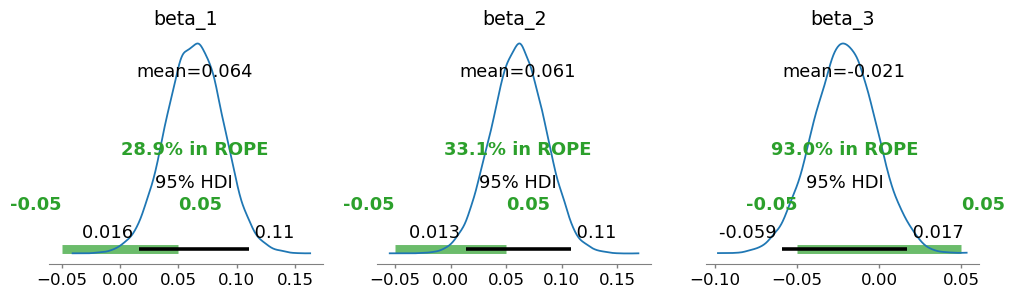

In [22]:
# 定义 ROPE 区间，根据研究的需要指定实际等效范围
rope_interval = [-0.05, 0.05]

# 绘制后验分布，显示 HDI 和 ROPE
az.plot_posterior(
    model2_trace,
    var_names=["beta_1", "beta_2", "beta_3"],
    hdi_prob=0.95,
    rope=rope_interval,
    figsize=(12, 3),
    textsize=12
)

plt.show()

使用贝叶斯因子进行差异检验

- $beta_3$ 的 $BF_{01}$ 接近30，表明有较强的证据说明不同匹配条件下 $Y$ 的均值相同。

Sampling: [Y_obs, beta_0, beta_1, beta_2, beta_3, sigma]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


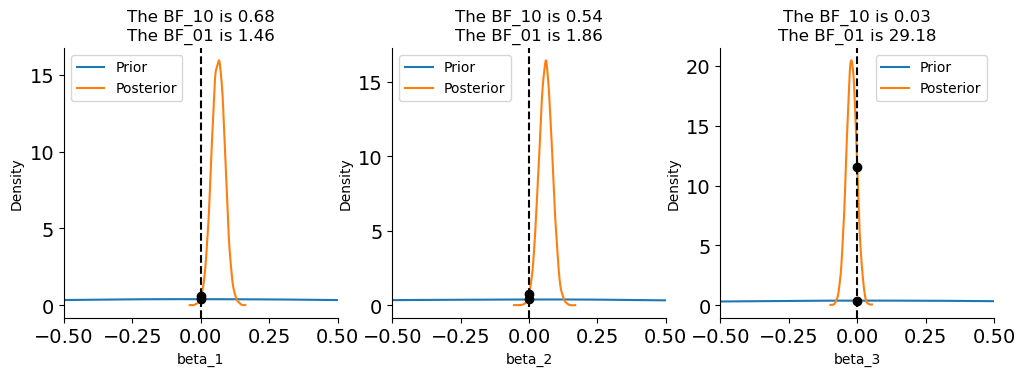

In [23]:
# 进行贝叶斯因子计算，需要采样先验分布
with model2:
    model2_trace.extend(pm.sample_prior_predictive(5000, random_seed=84735) )

fig, axes = plt.subplots(1,3, figsize=(12, 3.5))

# 绘制贝叶斯因子图
# beta1
ax = axes[0]
az.plot_bf(model2_trace, var_name="beta_1", ref_val=0, ax=ax)
ax.set_xlim(-0.5, 0.5) 
# beta2
ax = axes[1]
az.plot_bf(model2_trace, var_name="beta_2", ref_val=0, ax=ax)
ax.set_xlim(-0.5, 0.5) 
# beta3
ax = axes[2]
az.plot_bf(model2_trace, var_name="beta_3", ref_val=0, ax=ax)
ax.set_xlim(-0.5, 0.5) 

# 去除上框线和右框线
sns.despine()
plt.show()

**后验预测**

最后，我们可以使用 `pm.sample_posterior_predictive` 函数来生成后验预测。

并通过 `az.plot_ppc` 函数来绘制后验预测的基本结果。

In [24]:
with model2:
    model2_ppc = pm.sample_posterior_predictive(model2_trace, random_seed=84735) 

Sampling: [Y_obs]


Output()

<Axes: xlabel='Y_obs'>

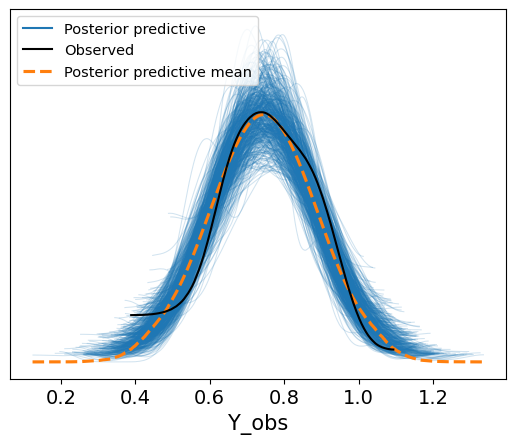

In [25]:
az.plot_ppc(model2_ppc, num_pp_samples = 500)

In [26]:
import xarray as xr

# 导入真实的自变量
X1 = xr.DataArray((df['Label'] == 'Friend').astype(int))
X2 = xr.DataArray((df['Label'] == 'Stranger').astype(int))
Matching = xr.DataArray((df['Matching'] == 'matching').astype(int))

model2_trace.posterior["y_model"] = model2_trace.posterior["beta_0"] + model2_trace.posterior["beta_1"] * X1 + model2_trace.posterior["beta_2"] * X2 + model2_trace.posterior["beta_3"] * Matching

df["model2_prediction"] = model2_trace.posterior.y_model.mean(dim=["chain","draw"]).values

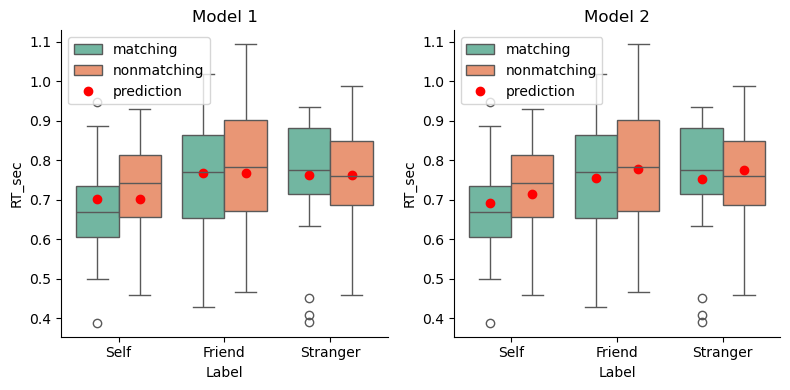

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 在第一个子图上绘制 Model 1 的预测结果
plot_prediction(df, predicted_y="model1_prediction", ax=axes[0])
axes[0].set_title("Model 1")

# 在第二个子图上绘制 Model 2 的预测结果
plot_prediction(df, predicted_y="model2_prediction", ax=axes[1])
axes[1].set_title("Model 2")

# 显示图形
sns.despine()
plt.tight_layout()
plt.show()


从模型预测结果来看：
- 模型一中，不同匹配条件下的反应时预测相同；但在模型二中，不同匹配条件下的反应时预测不同，说明匹配条件对反应时存在影响。
- 但在模型二中，无论标签如何，模型预测的匹配效应相同，这是因为模型二没有考虑标签“Label”和匹配条件“Matching”的交互作用。

## 模型三：带交互项的2 X 3 的多元线性回归  


**交互作用：** 当模型存在两个或两个以上的自变量时，交互作用是指一个自变量$X_1$对因变量$Y$的影响会随着自变量$X_2$不同水平的变化而有所差异。

当我们考虑交互效应时，模型不仅包含 “Label” 和 “Matching” 的独立主效应，还需要加入它们之间的交互作用。

加入交互项可以观察 “Label” 和 “Matching” 是否存在相互依赖的影响，即 “Matching” 对 “Self、Friend 和 Stranger” 条件的影响是否不同。

通过引入交互项，我们能够捕捉变量之间的相互关系。

**多个理解变量下，不同编码和研究效应的关系**

如图所示，表中列出了 Treatment Coding 和 Sum Coding 两种常用的因子变量编码方式，并展示了它们在研究主效应和交互效应时的特点：

<div style="text-align: center;">
    <img src="https://pic3.zhimg.com/80/v2-f95e51b7e6e26feab9ca91077d9c244e_1440w.webp" 
         alt="Image Description" 
         style="width: 80%; height: auto;">
</div>

> 参考资料：
> [线性（混合）模型中如何对因子变量事先生成虚拟变量 - 知乎](https://zhuanlan.zhihu.com/p/103547646)

<div style="padding-bottom: 30px;"></div>


### 哑变量编码规则

增加了交互效应后的线性模型的编码规则应该是：

1. **主效应的编码规则：**
   - **Label (3 levels):**
     - $( X_{L1} = 1)$ 表示 "Friend" 条件；$( X_{L1} = 0 )$ 表示其他条件;
     - $( X_{L2} = 1 )$ 表示 "Stranger" 条件；$( X_{L2} = 0 )$ 表示其他条件;
     - $( Self)$ 为基线水平，不需要单独编码（隐含在 $( X_{L1} = 0, X_{L2} = 0)$ 中）。

   - **Matching (2 levels):**
     - $( X_{M1} = 1)$ 表示 "nonmatching" 条件；
     - $( X_{M1} = 0 )$ 表示 "matching" 条件（基线水平）。

2. **交互项的编码规则：**
   - **交互项 $( X_{L1} \cdot X_{M1} )$:**
     - 当 $( X_{L1} = 1) 且 ( X_{M1} = 1)$ 时，交互项 $( X_{L1} \cdot X_{M1} = 1)$。
     - 否则，$( X_{L1} \cdot X_{M1} = 0 )$。

   - **交互项 $( X_{L2} \cdot X_{M1})$:**
     - 当 $( X_{L2} = 1)$ 且 $( X_{M1} = 1)$ 时，交互项 $( X_{L2} \cdot X_{M1} = 1)$。
     - 否则，$( X_{L2} \cdot X_{M1} = 0)$。

**Treatment编码矩阵**


| Label     | Matching    | 截距 (baseline) | $X_{L1}$ | $X_{L2}$ | $X_{M1}$ | $X_{L1} \cdot X_{M1}$  | $X_{L2} \cdot X_{M1}$ |
|-----------|-------------|-----------------|--------------|--------------|--------------|---------------------------|---------------------------|
| Self      | matching    | 1               | 0            | 0            | 0            | 0                         | 0                         |
| Self      | nonmatching | 1               | 0            | 0            | 1            | 0                         | 0                         |
| Friend    | matching    | 1               | 1            | 0            | 0            | 0                         | 0                         |
| Friend    | nonmatching | 1               | 1            | 0            | 1            | 1                         | 0                         |
| Stranger  | matching    | 1               | 0            | 1            | 0            | 0                         | 0                         |
| Stranger  | nonmatching | 1               | 0            | 1            | 1            | 0                         | 1                         |


<div style="padding-bottom: 80px;"></div>

### 模型设定

在了解哑变量之后，我们就可以开始进行模型拟合和推断了。

有交互项的 2 X 3 的线性回归模型表达为：

$$
Y = \beta_0 + \beta_1 \cdot X_{L1} + \beta_2 \cdot X_{L2} + \beta_3 \cdot X_{M1} + \beta_4 \cdot (X_{L1} \cdot X_{M1}) + \beta_5 \cdot (X_{L2} \cdot X_{M1}) + \epsilon_i
$$

在这个模型中：

- $ X_{L1} \cdot X_{M1} $ 表示在“Label”条件中 “Friend” 水平和 “Matching” 条件中和“nonmatching” 水平的交互作用。

- $ X_{L2} \cdot X_{M1} $ 表示在“Label”条件中 “stranger” 水平和 “Matching” 条件中和“nonmatching”水平的交互作用。

**模型先验设置**

现在我们的线性模型中增加了交互效应，那么我们需要对$\beta_4$ 和 $\beta_5$设置先验分布，即：

- $\beta_4$ 和 $\beta_5$ ： 
$$ \beta_4 \sim N(0, 1^2), \quad \beta_5 \sim N(0, 1^2) $$

- $\beta_0$： 
$$ \beta_0 \sim N(5, 2^2) $$

- $\beta_1$ , $\beta_2$ 和$\beta_3$：
$$ \beta_1 \sim N(0, 1^2),  \beta_2 \sim N(0, 1^2)  , \beta_3 \sim N(0, 1^2) $$

- $\sigma$： 
$$ \sigma \sim Exp(0.3) $$


先验设置：

* > $Y_i \sim N\left(\mu_i, \sigma^2\right)$

* > $\sigma \sim \text{Exp}(0.3)$

* > $\beta_0 \sim N\left(5, 2^2\right)$

* > $\beta_1 \sim N\left(0, 1^2\right)$

* > $\beta_2 \sim N\left(0, 1^2\right)$

* > $\beta_3 \sim N\left(0, 1^2\right)$

* > $\beta_4 \sim N\left(0, 1^2\right)$

* > $\beta_5 \sim N\left(0, 1^2\right)$

定义回归模型：

* > $\mu_i = \beta_0 + \beta_1 X_{L1} + \beta_2 X_{L2} + \beta_3 X_{M1} + \beta_4 (X_{L1} \cdot X_{M1}) + \beta_5 (X_{L2} \cdot X_{M1})$

### 模型拟合和推断

我们可以通过 PyMC 构建该模型，并使用 MCMC 算法进行采样。

In [28]:
# 转换分类变量为哑变量
X1 = (df['Label'] == 'Friend').astype(int)
X2 = (df['Label'] == 'Stranger').astype(int)

# Matching 条件的哑变量
Matching = (df['Matching'] == 'matching').astype(int)  

# Friend 和 Matching 的交互
Interaction_1 = X1 * Matching  
# Stranger 和 Matching 的交互
Interaction_2 = X2 * Matching  

In [29]:
import pymc as pm

with pm.Model() as model3:
    # 定义先验分布
    beta_0 = pm.Normal('beta_0', mu=5, sigma=2)  
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1) 
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)  
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)  
    beta_4 = pm.Normal('beta_4', mu=0, sigma=1) 
    beta_5 = pm.Normal('beta_5', mu=0, sigma=1)  
    sigma = pm.Exponential('sigma', lam=0.3)  
    
    # 线性模型
    mu = (beta_0 + beta_1 * X1 + beta_2 * X2 + beta_3 * Matching +
          beta_4 * Interaction_1 + beta_5 * Interaction_2)
    
    # 观测数据的似然函数
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=df['RT_sec'])


**进行后验采样**

接下来我们使用`pm.sample()`进行mcmc采样  

In [30]:
with model3:
    model3_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                             tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                             chains=4,                     # 链数
                             discard_tuned_samples=True,  # tune的结果将在采样结束后被丢弃
                             random_seed=84735)           # 后验采样  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3, beta_4, beta_5, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.


**MCMC诊断和后验推断**

我们可以使用 `az.summary` 函数来查看诊断和后验推断的摘要。

In [31]:
az.summary(model3_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.728,0.024,0.683,0.774,0.000,0.0,7122.0,9651.0,1.0
beta_1,0.048,0.034,-0.017,0.111,0.000,0.0,8056.0,11444.0,1.0
beta_2,0.032,0.034,-0.033,0.096,0.000,0.0,7943.0,10889.0,1.0
beta_3,-0.051,0.034,-0.116,0.012,0.000,0.0,7127.0,10338.0,1.0
beta_4,0.031,0.048,-0.060,0.122,0.001,0.0,8148.0,12242.0,1.0
beta_5,0.058,0.048,-0.032,0.149,0.001,0.0,8253.0,11786.0,1.0
sigma,0.133,0.007,0.120,0.147,0.000,0.0,15559.0,12979.0,1.0


使用 ROPE+HDI 对参数进行检验

- 可以看到，$beta_4$ 和 $beta_5$ 非常接近0，表明没有交互效应。 

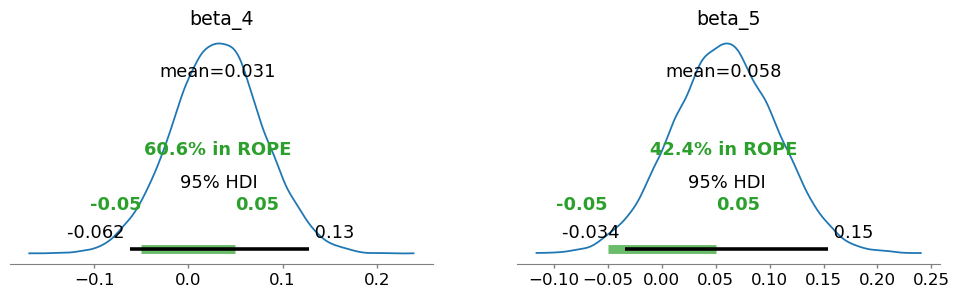

In [32]:
# 定义 ROPE 区间，根据研究的需要指定实际等效范围
rope_interval = [-0.05, 0.05]

# 绘制后验分布，显示 HDI 和 ROPE
az.plot_posterior(
    model3_trace,
    var_names=["beta_4", "beta_5"],
    hdi_prob=0.95,
    rope=rope_interval,
    figsize=(12, 3),
    textsize=12
)

plt.show()

使用贝叶斯因子进行差异检验

- $beta_4$ 和 $beta_5$ 的 $BF_{01}$z 在10～20之间，表明有证据说明不存在交互作用。

Sampling: [Y_obs, beta_0, beta_1, beta_2, beta_3, beta_4, beta_5, sigma]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


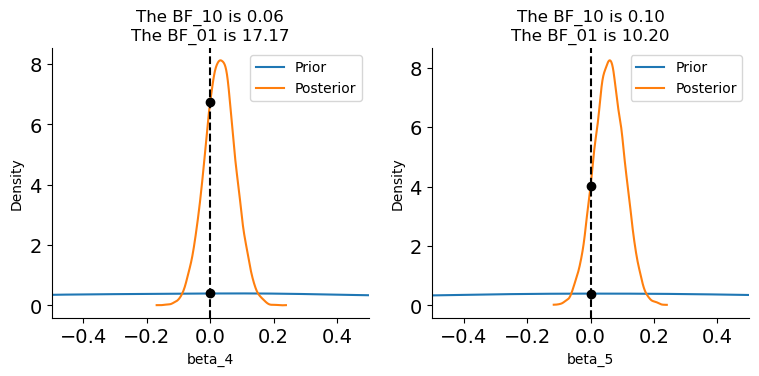

In [33]:
# 进行贝叶斯因子计算，需要采样先验分布
with model3:
    model3_trace.extend(pm.sample_prior_predictive(5000, random_seed=84735) )

fig, axes = plt.subplots(1,2, figsize=(9, 3.5))

# 绘制贝叶斯因子图
# beta4
ax = axes[0]
az.plot_bf(model3_trace, var_name="beta_4", ref_val=0, ax=ax)
ax.set_xlim(-0.5, 0.5) 
# beta5
ax = axes[1]
az.plot_bf(model3_trace, var_name="beta_5", ref_val=0, ax=ax)
ax.set_xlim(-0.5, 0.5) 

# 去除上框线和右框线
sns.despine()
plt.show()

**后验预测**

最后，我们可以使用 `pm.sample_posterior_predictive` 函数来生成后验预测。

并通过 `az.plot_ppc` 函数来绘制后验预测的基本结果。

In [34]:
with model3:
    model3_ppc = pm.sample_posterior_predictive(model3_trace, random_seed=84735) 

Sampling: [Y_obs]


Output()

<Axes: xlabel='Y_obs'>

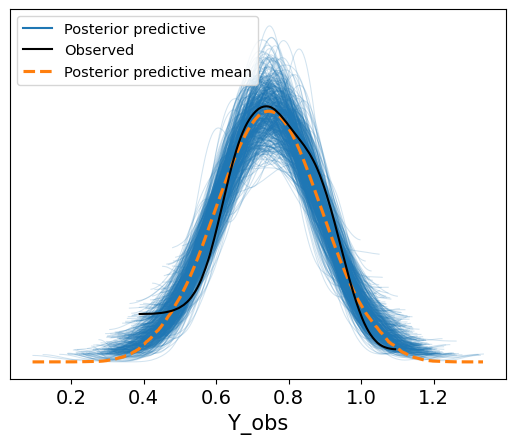

In [35]:
az.plot_ppc(model3_ppc, num_pp_samples = 500)

In [36]:
import xarray as xr

# 导入真实的自变量
X1 = xr.DataArray((df['Label'] == 'Friend').astype(int))
X2 = xr.DataArray((df['Label'] == 'Stranger').astype(int))
Matching = xr.DataArray((df['Matching'] == 'matching').astype(int))
Interaction_1 = X1 * Matching
Interaction_2 = X2 * Matching

model3_trace.posterior["y_model"] = model3_trace.posterior["beta_0"] + \
    (model3_trace.posterior["beta_1"] * X1) + \
    (model3_trace.posterior["beta_2"] * X2) + \
    (model3_trace.posterior["beta_3"] * Matching) + \
    (model3_trace.posterior["beta_4"] * Interaction_1) + \
    (model3_trace.posterior["beta_5"] * Interaction_2)

df["model3_prediction"] = model3_trace.posterior.y_model.mean(dim=["chain","draw"]).values

In [37]:
df['Label'] = df['Label'].astype(str)

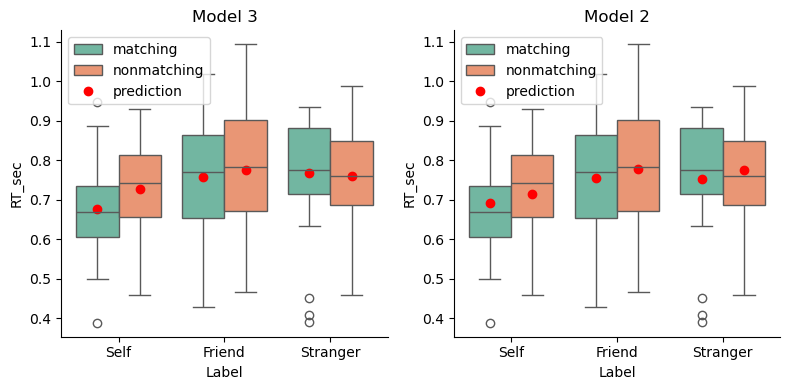

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 绘制model3预测结果
plot_prediction(df, "model3_prediction", ax=axes[0])
axes[0].set_title("Model 3")

# 绘制model2预测结果
plot_prediction(df, "model2_prediction", ax=axes[1])
axes[1].set_title("Model 2")

# 显示图像
sns.despine()
plt.tight_layout()
plt.show()


In [41]:
print(axes)


[<Axes: title={'center': 'Model 3'}, xlabel='beta_4', ylabel='Density'>
 <Axes: title={'center': 'Model 2'}, xlabel='beta_5', ylabel='Density'>]


相较于模型2，模型3考虑了匹配条件与标签之间的交互作用，因此可以更准确地捕捉反应时间随标签和匹配条件变化的非线性关系。

- 具体表现为，在 “stranger” 条件下，匹配条件对反应时间几乎没有影响。模型3能够捕捉到这一特性，而模型2则不能。

## 模型解读与结论

通过贝叶斯回归模型的后验分布，我们可以推断以下几个方面：
- **反应时间与标签的关系**：根据 $\beta_1$  和  $\beta_2$ 的估计值，我们可以判断不同标签条件下反应时间的差异（自我对比其他标签）。
- **匹配条件的影响**：通过 $\beta_1$，我们可以判断是否匹配条件会显著影响反应时间。
- **交互效应**：通过 $\beta_4$ 和 $\beta_5$ 的估计，我们可以了解匹配条件与标签之间的交互作用是否显著，尤其是在自我与他人标签的反应时间是否有显著差异。

思考题：贝叶斯回归模型与传统的线性回归模型得到的结论是否一致？


## 练习

在以下的练习中，我们需要采用上述的思路，在另一个问题情境下使用贝叶斯的线性回归来解决问题。

### 背景介绍

> * 🤦‍♀️🤦‍♀️当你压力大时，或许也曾：疯狂购物、沉迷游戏；但有的时候，当你感觉到压力大时，或许也曾：卸载软件，聚精会神  
> * 从直觉上我们能感受到似乎压力与自我控制之间存在某种联系  

我们使用的数据来自Human Penguin Project (Hu et al., 2018, doi: 10.17605/OSF.IO/H52D3)，该项目使用了多种常见的心理测量量表，并在跨国人群中进行施测，其中包含了测量压力与自我控制的量表。  

- 测量压力的量表共有14道题，每道题的标尺有5个水平，分值为1-5，总分的分布范围为14-70  

- 测量自我控制的量表共有13道题，每道题的标尺有5个水平，分值为1-5，总分的分布范围为13-65  

> * 数据来源: Hu, C.-P. et al. (2018). Raw data from the Human Penguin Project. Open Science Framework. https://doi.org/10.17605/OSF.IO/H52D3  
> * 压力量表来源：Cohen, S., Kamarck, T. & Mermelstein, R. A global measure of perceived stress. J. Health. Soc. Behav. 24, 385–396 (1983).  
> * 自我控制量表来源：Tangney, J. P., Baumeister, R. F. & Boone, A. L. High self-control predicts good adjustment, less pathology, better grades, and interpersonal success. J. Pers. 72, 271–324 (2004).

**使用线性模型表示二者关系**  

* 在这个例子中，我们将每个被试的自我控制水平设为$Y$，压力水平设为$X$。在收集完n个被试的数据后，我们可以得到：  

$$  
\left\lbrace (Y_1,X_1), (Y_2,X_2),...,(Y_n,X_n) \right\rbrace  
$$  

* 我们可以使用线性模型来描述$Y$与$X$的关系，常见地，我们会将二者的关系写为：  

$$  
Y_i = \beta_0 + \beta_1 X_{i1} + \epsilon \;\;\;\;\;\;\;\;\epsilon \sim N(0,\sigma^2)\\  
$$  

*($\beta_0$为截距，$\beta_1$为斜率，$\epsilon$为残差)*  

#### 模型4定义  

现在，我们可以为参数$(\beta_0, \beta_1, \sigma)$设置先验： 

* > $Y_i {\sim} N\left(\mu_i, \sigma^2\right)$  

* > $\sigma   \sim \text{Exp}(0.6)$  
  
* > $\beta_{0}   \sim N\left(50, 10^2 \right)$  

* > $\beta_1   \sim N\left(0, 10^2 \right)$  
  
定义回归模型：
* > $\mu_i = \beta_0 + \beta_1 X_i$



In [39]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

In [ ]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
try:
    df_re = pd.read_csv('/home/mw/input/bayes3797/Data_Sum_HPP_Multi_Site_Share.csv')
except:
    df_re= pd.read_csv('data/Data_Sum_HPP_Multi_Site_Share.csv')


# 筛选站点为"Tsinghua"的数据
df = df_re[df_re["Site"] == "Tsinghua"]

df = df[["stress","scontrol","smoke"]]

#1 表示吸烟，2表示不吸烟
df["smoke"] =  np.where(df['smoke'] == 2, 0, 1)
df["smoke_recode"] =  np.where(df['smoke'] == 1, "yes", "no")


#设置索引
df["index"] = range(len(df))
df = df.set_index("index")

#### 任务1：根据数据和模型定义 PyMC 模型

In [ ]:
with pm.Model() as model4:
    
    ##---------------------------
    #     定义参数先验，包括 beta_0，beta_1，sigma
    #---------------------------
    beta_0 = ...          
    beta_1 = ...
    sigma = ...


    x = pm.MutableData("x",df.stress)                    #x是自变量压力水平
    ##---------------------------
    #     定义回归模型
    #---------------------------
    mu = ...                              

    ##---------------------------
    #     定义似然函数
    #---------------------------
    likelihood = ...

#### 任务2：拟合模型并进行 MCMC 检查

In [ ]:
##---------------------------
#     对模型 model4 进行 MCMC 采样
#---------------------------
...

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


In [ ]:
##---------------------------
#     通过可视化+统计指标检验 MCMC 是否收敛，当你顺利运行了这段代码，可以举手示意助教/老师帮助你检查其模型建立的是否正确
#     提示：可以使用 az.az.plot_trace() 和 az.summary()函数
#---------------------------
...

#### 任务3：使用 HDI 或者 BF 进行模型推断

In [ ]:
##---------------------------
#     参考前面的代码计算 HDI + ROPE 区间 或者贝叶斯因子计算
#---------------------------
...

#### 任务4：进行后验预测

In [ ]:
##---------------------------
#     对模型进行后验预测
#---------------------------
with model4:
    model4_ppc = ...

Sampling: [y_est]


Output()

In [ ]:
##---------------------------
#     可视化后验预测结果
#     提示：可以使用 az.plot_ppc(...)
#---------------------------
...

### 模型5：增加预测变量  


🤔 是否可以将吸烟情况和压力同时加入到目前的模型4中?  

如果我们现在将吸烟情况加入到目前的模型中的话，我们的线性回归模型则会更新为：

$$  
Y_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \epsilon \;\;\;\;\;\;\;\;\epsilon \sim N(0,\sigma^2)\\  
$$  

- $X_{i1}$ 是第$i$个被试的压力水平;
- $X_{i2}$ 是第$i$个被试的吸烟状态，$X_{i2} = 0$ 表示不吸烟，$X_{i2} =1$ 表示吸烟;



*($\beta_0$为截距，$\beta_1$为斜率，$\epsilon$为残差)*  

**各参数(回归系数)的意义：**  

在现在的例子中，自变量包括离散变量和连续变量。  

在自变量中，$X_{i2}$为离散变量，`0` 表示不吸烟，`1`表示吸烟  

* 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2 \cdot 0 = \beta_0 + \beta_1X_{i1}$  

    * 表示不吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。  

* 当$X_{i2} = 1$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2 \cdot 1 = (\beta_0 + \beta_2) + \beta_1X_{i1}$  

    * 表示吸烟情况下，自我控制分数随压力分数变化的情况。  

> 注意，在该模型中，我们假设在两种吸烟条件下，压力对自我控制的影响是相同的，即不存在吸烟对于压力的调节作用。

现在，我们可以结合数据与先验，为参数$(\beta_0, \beta_1, \beta_2, \sigma)$生成后验模型  

* 当后验分布过于复杂时，我们可以使用MCMC来近似后验分布  

    * 我们使用PyMC来完成采样过程  


我们的先验设置： 

* > $Y_i {\sim} N\left(\mu_i, \sigma^2\right)$  

* > $\beta_{0}   \sim N\left(50, 10^2 \right)$  

* > $\beta_1   \sim N\left(0, 10^2 \right)$  

* > $\beta_2   \sim N\left(0, 10^2 \right)$  

* > $\sigma   \sim \text{Exp}(0.6)$  

定义回归模型：
* > $\mu_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i}$

#### 任务1：根据数据和模型定义 PyMC 模型

In [ ]:
with pm.Model() as model5:
    ##---------------------------
    #     定义参数先验，包括 beta_0，beta_1，sigma
    #---------------------------
    beta_0 = ...          
    beta_1 = ...
    beta_2 = ...
    sigma = ...


    stress = pm.MutableData("stress",df.stress, dims="obs_id")      #stress是自变量压力水平
    smoke = pm.MutableData("smoke",df.smoke, dims="obs_id")         #smoke是自变量吸烟水平
    ##---------------------------
    #     定义回归模型
    #---------------------------
    mu = pm.Deterministic("mu", ..., dims="obs_id")    #定义mu，自变量与先验结合

    ##---------------------------
    #     定义似然函数
    #---------------------------
    likelihood = pm.Normal("y_est", mu=..., sigma=..., observed=..., dims="obs_id") 

#### 任务2：拟合模型并进行 MCMC 检查

In [ ]:
##---------------------------
#     对模型 model5 进行 MCMC 采样
#     注意！！！以下代码可能需要运行1-2分钟左右
#---------------------------
...

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


In [ ]:
##---------------------------
#     通过可视化+统计指标检验 MCMC 是否收敛，，当你顺利运行了这段代码，可以举手示意助教/老师帮助你检查其模型建立的是否正确
#     提示：可以使用 az.az.plot_trace() 和 az.summary()函数
#---------------------------
...

#### 任务3：使用 HDI 或者 BF 进行模型推断

In [ ]:
##---------------------------
#     参考前面的代码计算 HDI + ROPE 区间 或者贝叶斯因子计算
#---------------------------
...

#### 任务4：进行后验预测

In [ ]:
##---------------------------
#     对模型进行后验预测
#---------------------------
with model5:
    model5_ppc = ...

Sampling: [y_est]


Output()

In [ ]:
##---------------------------
#     可视化后验预测结果
#     提示：可以使用 az.plot_ppc(...)
#---------------------------
...

### 多元线性回归：增加交互项  
 
现在，我们可以假设，在不同的吸烟状况下，压力对自我控制的影响略有不同(体现在斜率上)  

![Image Name](https://cdn.kesci.com/upload/s49oqb24we.png?imageView2/0/w/960/h/960)

那么我们可以加入交互项：$\mu = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + \beta_3 X_{1}X_{2}$  

$$  
\begin{equation}  
\begin{array}{lcrl}  
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\beta_3,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \beta_3X_{i1}X_{i2} \\  
\text{priors:} & & \beta_{0c}  &  \sim N\left(50, 10^2 \right)  \\  
                     & & \beta_1  & \sim N\left(0, 10^2 \right) \\  
                     & & \beta_2  & \sim N\left(0, 10^2 \right) \\  
                     & & \beta_3  & \sim N\left(0, 10^2 \right) \\  
                     & & \sigma & \sim \text{Exp}(0.6)  .\\  
\end{array}  
\end{equation}  
$$  


先验设置如下：

* > $Y_i \sim N\left(\mu_i, \sigma^2\right)$

* > $\sigma \sim \text{Exp}(0.6)$

* > $\beta_0 \sim N\left(50, 10^2\right)$

* > $\beta_1 \sim N\left(0, 10^2\right)$

* > $\beta_2 \sim N\left(0, 10^2\right)$

* > $\beta_3 \sim N\left(0, 10^2\right)$

定义回归模型：

* > $\mu_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 X_{i1}X_{i2}$

**在这个例子中，各参数的意义：**  

* 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1}$  

    * 表示不吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。  

* 当$X_{i2} = 1$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \beta_3X_{i1} = (\beta_0 +\beta_2) + (\beta_1 + \beta_3)X_{i1}$  

    * 表示吸烟情况下，自我控制分数随压力分数变化的情况  
    * 注意截距项和斜率项的变化  
    * 此时压力对自我控制的影响为$(\beta_1 + \beta_3)$，体现了吸烟对这一关系的影响  


#### 任务1：根据数据和模型定义 PyMC 模型

In [ ]:
with pm.Model() as model6:
    
    ##---------------------------
    #     定义参数先验，包括 beta_0，beta_1，sigma
    #---------------------------
    beta_0 = ...       
    beta_1 = ...
    beta_2 = ...
    beta_3 = ...
    sigma = ...

    stress = pm.MutableData("stress",df.stress, dims="obs_id")      #stress是自变量压力水平
    smoke = pm.MutableData("smoke",df.smoke, dims="obs_id")         #smoke是自变量吸烟水平
    ##---------------------------
    #     定义回归模型
    #---------------------------
    mu = pm.Deterministic("mu", ..., dims="obs_id")      #定义mu，将自变量与先验结合

    ##---------------------------
    #     定义似然函数
    #---------------------------
    likelihood = pm.Normal("y_est", mu=..., sigma=..., observed=..., dims="obs_id") 

#### 任务2：拟合模型并进行 MCMC 检查

In [ ]:
##---------------------------
#     对模型 model6 进行 MCMC 采样
#     注意！！！以下代码可能需要运行1-2分钟左右
#---------------------------
...

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.


In [ ]:
##---------------------------
#     通过可视化+统计指标检验 MCMC 是否收敛，当你顺利运行了这段代码，可以举手示意助教/老师帮助你检查其模型建立的是否正确
#     提示：可以使用 az.az.plot_trace() 和 az.summary()函数
#---------------------------
...

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,55.702,2.518,50.968,60.494,0.026,0.018,9734.0,9482.0,1.0
beta_1,-0.405,0.062,-0.521,-0.286,0.001,0.000,9689.0,8801.0,1.0
beta_2,0.758,7.125,-12.268,14.453,0.070,0.058,10489.0,10679.0,1.0
beta_3,-0.068,0.186,-0.430,0.267,0.002,0.001,10353.0,10588.0,1.0
mu[0],40.329,0.445,39.526,41.200,0.003,0.002,19487.0,16883.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[170],38.711,0.452,37.889,39.580,0.003,0.002,20697.0,17363.0,1.0
mu[171],38.711,0.452,37.889,39.580,0.003,0.002,20697.0,17363.0,1.0
mu[172],39.925,0.434,39.138,40.767,0.003,0.002,21100.0,16794.0,1.0
mu[173],42.352,0.605,41.215,43.492,0.005,0.004,12929.0,14035.0,1.0


#### 任务3：使用 HDI 或者 BF 进行模型推断

In [ ]:
##---------------------------
#     参考前面的代码计算 HDI + ROPE 区间 或者贝叶斯因子计算
#---------------------------
...

#### 任务4：进行后验预测

In [ ]:
##---------------------------
#     对模型进行后验预测
#---------------------------
with model6:
    model6_ppc = ...

Sampling: [y_est]


Output()

In [ ]:
##---------------------------
#     可视化后验预测结果
#     提示：可以使用 az.plot_ppc(...)
#---------------------------
...

## 总结

🤔虽然我们现在已经学习了使用不同的线性回归模型来拟合变量间的关系，但有些问题我们暂时忽略了：  
1. 如何评估不同的模型？哪个模型最好？  
2. 什么时候该使用什么模型？
![Image Name](https://cdn.kesci.com/upload/image/rkz1dqyo2e.png?imageView2/0/w/960/h/960)


接下来，我们需要对模型进行**评估**  

* 我们可以从以下三个角度来思考这个问题：  

    1. 模型本身公正吗？(How fair is the model?)  

    2. 模型存在错误吗？(How wrong is the model?)  

    3. 后验预测模型有多准确？(How accurate are the posterior predictive models?)  


## 模型公正吗(Is the model fair?)  

模型公正性是一个上位概念，它描述了模型是否符合我们(社会、道德、伦理)的预期，而不仅是关注模型和样本数据的关系。  

我们可以借助几个相关问题来理解和思考模型的公众性：  

1. 数据的收集过程是怎样的？  

2. 数据由谁收集，数据收集的目的是什么？  

3. 数据收集的过程，以及分析的结果，将对个人和社会产生什么影响？  

4. 分析过程中可能会包含哪些偏见  
    * p-hacking/HARKing

**1. 数据的收集的过程公平吗？**  

在本示例研究中，数据来源于基于自我匹配范式的实验数据，这些数据通过线下认知实验收集而得。

* 数据收集过程是公平的，被试填写了实验的知情同意书，并获得相应的报酬。  
* 此外，数据收集过程是匿名化的，保护了被试的隐私。  

极端的反例，如：  
* 在数据收集过程中，仅选取大学生群体作为样本，而忽略其他重要的人群。

🤔基于这些数据的模型公正吗？  


**2. 研究目的，以及数据收集的目的公平吗？**  

在本示例研究中，研究目的来源自心理学家的好奇和假设。这是合理的，因为心理学研究是一种探索性的研究方法。  

一些极端的反例：  
* 如果研究项目来源于开发缓解压力药的厂商。那么，研究目的就可能被操纵，以支持药厂的销售。  
* 例如，有目的的选择被试。  
* 例如，有目的性的将实验目告诉被试，从而收集到符合预期的数据。

**3. 模型分析的结果，将对个人和社会产生什么影响？**  

在本示例研究中，研究结果(模型分析的结果)具有一定的理论意义和实际意义。  
* 在理论层面， 自我匹配范式中的模型能够帮助揭示个体如何处理与“自我”相关的信息。
* 在实际意义层面，通过这些模型，可以更精确地识别个体在自我认知过程中的偏差。 

**4. 分析过程中包含的偏见？**  

一些反例：  
* 假设在一次研究中使用多种问卷收集多种因变量，然后选择有相关性的变量进行报告?  
* 在多因素实验设计中，通过增加变量来获得显著的交互作用，并尝试多种简单效应分析。

在心理学研究中，模型公正性往往与***心理学研究的可重复性***相关。  

1. 数据的收集过程是怎样的？  

2. 数据由谁收集，数据收集的目的是什么？  

3. 数据收集的过程，以及分析的结果，将对个人和社会产生什么影响？  

4. 分析过程中可能会包含哪些偏见  
    * p-hacking/HARKing  

<div style="text-align: center;">
    <img src="https://pic2.zhimg.com/80/v2-778de6c621356bc2c23c3a09ff2b0be5_1440w.webp" 
         alt="Image Description" 
         style="width: 60%; height: auto;">
</div>

(来源：胡传鹏, ..., 彭凯平. (2016). 心理学研究中的可重复性问题:从危机到契机. 心理科学进展(9), 15.)

虽然贝叶斯模型无法直接回答“模型是否公平”这个问题，但它能更好地整合前提假设和先验知识。通过模型比较的方式，贝叶斯方法可以帮助我们发现模型中的潜在错误，以及模型的预测能力。🔍

模型公正的三大思考角度：
1. 模型本身公平吗？ 🤔
2. 模型有错误吗？ ❌
3. 后验预测模型有多准确？ 🎯

### 这个模型可能有多错误(How wrong is the model?)  


>  **<center>“all models are wrong, but some are useful.   ————George Box”</center>**  


* 尽管统计模型是对更复杂现实的简化表达，良好的统计模型仍然可以是有用的，并可以增进我们对世界复杂性的理解。  

* 因此，在评估模型时，要问的下一个问题不是模型是否错误(is the model wrong?)，而是模型错误的程度(How wrong is the model?)  

🤔思考贝叶斯线性回归模型的假设在多大程度上与现实相符？


**在贝叶斯中，模型评估主要会通过绝对指标和相对指标来进行评估，我们会在下一节课详细介绍。**


**概念区别：模型诊断(model diagnostic) vs. 模型验证(model validation)**  

在贝叶斯的workflow中，  

- MCMC评估是对MCMC进行检验，在Gelman et al (2020)中也被称为计算过程的验证(validate computation)，其核心在于确定MCMC算法采样得到的样本是否足以提供目标分布的精确近似。  

- 模型评估则是指对模型是否公平性、有效性、可信性进行评估，既可以是对单个模型，也可以是对多个模型进行。  

理想情况下，两种评估结果都是良好的。然而，情况并非总是如此。  
  - 我们可能有一个很好的模型框架，但是MCMC链的结果却不稳定，进而导致不准确的后验近似。  
  - 或者刚好相反，我们可以获得很好地后验近似，但模型本身却并不反映任何事实。  

![Image Name](https://cdn.kesci.com/upload/image/rkz1dqyo2e.png?imageView2/0/w/960/h/960)